In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import datasets, layers, models, losses, optimizers, Input, optimizers
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from time import sleep
from sklearn.preprocessing import StandardScaler
import time
import pprint
tf.__version__

'2.8.0'

In [2]:
start = time.perf_counter()

In [3]:
len(tf.config.list_physical_devices('GPU'))>0

True

In [4]:
device_name = tf.test.gpu_device_name()
print(device_name)

/device:GPU:0


In [5]:
X_x_train = np.loadtxt("./data/X_x_train.txt")
X_y_train = np.loadtxt("./data/X_y_train.txt")
X_z_train = np.loadtxt("./data/X_z_train.txt")
y_train = np.loadtxt("./data/y_train.txt")

X_x_test = np.loadtxt("./data/X_x_train.txt")
X_y_test = np.loadtxt("./data/X_y_train.txt")
X_z_test = np.loadtxt("./data/X_z_train.txt")
y_test = np.loadtxt("./data/y_train.txt")

In [6]:
# for i, r in tqdm(X_x_train[:], total=X_x_train.shape[0], desc="printing graphs..."):
#     print("plot" +str(i))
#     row = X_x_train[i,:-1]
#     y = X_x_train[i,-1:]
#     print(label_names[int(y)-1])
#     plt.plot(row)
#     plt.show()


In [7]:
def standard_score_normalization(x):
    x_m = np.mean(x, axis=1).reshape(-1,1)
    x_std = np.std(x,axis=1).reshape(-1,1)
    return (x-x_m)/x_std

In [8]:
norm = StandardScaler()

In [9]:
X_x_train_norm = norm.fit_transform(X_x_train)
X_y_train_norm = norm.fit_transform(X_y_train)
X_z_train_norm = norm.fit_transform(X_y_train)

X_x_test_norm = norm.fit_transform(X_x_test)
X_y_test_norm = norm.fit_transform(X_y_test)
X_z_test_norm = norm.fit_transform(X_z_test)

### Below I'm comparing two different concatenation functions.

concat_xyz is vectorizing calculations while concat2_xyz is iterating

In [10]:
def concat_xyz(x,y,z):
    data = np.empty((x.shape[0],x.shape[1],3))
#     x = np.expand_dims(x, axis=1) # same as x = x[:,np.newaxis,:]
#     y = np.expand_dims(y, axis=1)
#     z = np.expand_dims(z, axis=1)
    data[:,:,0] = x
    data[:,:,1] = y
    data[:,:,2] = z
    return data

In [11]:
#speed test purposes
def concat2_xyz(x,y,z):
    data = np.empty((x.shape[0],x.shape[1],3))
    for i, rowx,rowy, rowz in zip(range(x.shape[0]),x,y,z):
        data[i,:,0] = rowx.reshape(1,-1)
        data[i,:,1] = rowy.reshape(1,-1)
        data[i,:,2] = rowz.reshape(1,-1)
    return data

In [12]:
tic = time.perf_counter()
X_xyz_norm_train =  concat_xyz(X_x_train_norm,X_y_train_norm, X_z_train_norm)
X_xyz_norm_test = concat_xyz(X_x_test_norm,X_y_test_norm,X_z_test_norm)
toc = time.perf_counter()
print(f"concat_xyz in {toc - tic:0.4f} seconds")

concat_xyz in 0.0113 seconds


In [13]:
#speed test purposes
tic = time.perf_counter()
concat2_xyz(X_x_train_norm,X_y_train_norm, X_z_train_norm)
concat_xyz(X_x_test_norm,X_y_test_norm,X_z_test_norm)
toc = time.perf_counter()
print(f"concat2_xyz in {toc - tic:0.4f} seconds")

concat2_xyz in 0.0188 seconds


#### Vectorizing calculations is faster


In [14]:
label_names = ['Walking', 'Walking upstairs', 'Walking downstairs', 'Sitting', 'Standing', 'Laying']
num_outputs = len(label_names)

In [15]:
# one hot encoding

y_train = np.eye(len(label_names))[(y_train-1).astype(int)]
y_test = np.eye(len(label_names))[(y_train-1).astype(int)]

In [16]:
X_xyz_norm_train.shape

(7352, 128, 3)

In [17]:
input_shape = X_xyz_norm_train.shape[1:]

In TF1 placeholder would be needed to get shape of `(None, 128, 3)` but here we take `(128, 3)` as input shape instead

<H1>Implementing CNN</H1>

In [18]:
cnn = models.Sequential()
cnn.add(layers.Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=input_shape))
# cnn.add(layers.MaxPool1D(pool_size=2))
cnn.add(layers.Flatten())
cnn.add(layers.Dense(100, activation='relu'))
cnn.add(layers.Dense(30, activation='relu'))
cnn.add(layers.Dense(num_outputs,activation='softmax'))

In [19]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 127, 64)           448       
                                                                 
 flatten (Flatten)           (None, 8128)              0         
                                                                 
 dense (Dense)               (None, 100)               812900    
                                                                 
 dense_1 (Dense)             (None, 30)                3030      
                                                                 
 dense_2 (Dense)             (None, 6)                 186       
                                                                 
Total params: 816,564
Trainable params: 816,564
Non-trainable params: 0
_________________________________________________________________


In [20]:
# optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
cnn.compile(optimizer="adam",
           loss="categorical_crossentropy",
           metrics="accuracy")

In [21]:
cnnhistory = cnn.fit(X_xyz_norm_train, y_train, epochs=100, batch_size = 10)

Epoch 1/100
736/736 [==============================] - 4s 1ms/step - loss: 0.9375 - accuracy: 0.5233
Epoch 2/100
736/736 [==============================] - 1s 1ms/step - loss: 0.6909 - accuracy: 0.6344
Epoch 3/100
736/736 [==============================] - 1s 1ms/step - loss: 0.6256 - accuracy: 0.6798
Epoch 4/100
736/736 [==============================] - 1s 1ms/step - loss: 0.5869 - accuracy: 0.7221
Epoch 5/100
736/736 [==============================] - 1s 1ms/step - loss: 0.5208 - accuracy: 0.7550
Epoch 6/100
736/736 [==============================] - 1s 1ms/step - loss: 0.4831 - accuracy: 0.7715
Epoch 7/100
736/736 [==============================] - 1s 1ms/step - loss: 0.4556 - accuracy: 0.7882
Epoch 8/100
736/736 [==============================] - 1s 1ms/step - loss: 0.4456 - accuracy: 0.8014
Epoch 9/100
736/736 [==============================] - 1s 1ms/step - loss: 0.4276 - accuracy: 0.8074
Epoch 10/100
736/736 [==============================] - 1s 1ms/step - loss: 0.4150 - accura

In [22]:
# cnn.save("my_model")
# tensorflow_graph = tf.saved_model.load("my_model")
# x = np.random.uniform(size=(4, 32)).astype(np.float32)
# predicted = tensorflow_graph(x).numpy()

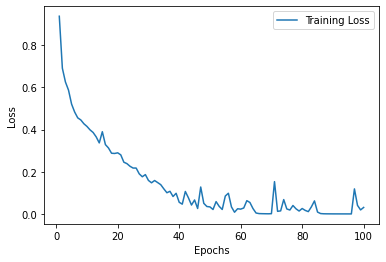

In [23]:
loss_values = cnnhistory.history['loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

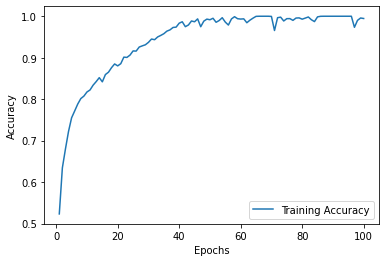

In [24]:
acc_values = cnnhistory.history['accuracy']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, acc_values, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [25]:
y_test_pred = cnn.predict(X_xyz_norm_test)
pprint.pprint(y_test_pred)
pprint.pprint(y_test)

array([[6.2674416e-18, 1.1517353e-16, 2.0504868e-19, 1.2353298e-05,
        9.9982893e-01, 1.5865134e-04],
       [9.3696127e-16, 2.6951659e-13, 1.1216037e-18, 1.4305064e-02,
        9.8569494e-01, 3.0592877e-09],
       [6.1417657e-13, 1.9131561e-11, 1.4100359e-14, 2.3432596e-05,
        9.9989712e-01, 7.9360325e-05],
       ...,
       [2.4183854e-12, 1.0000000e+00, 4.0419676e-09, 0.0000000e+00,
        0.0000000e+00, 6.7067713e-31],
       [8.8178197e-12, 1.0000000e+00, 2.8490710e-08, 0.0000000e+00,
        0.0000000e+00, 2.4869442e-26],
       [3.5985805e-11, 2.3819868e-02, 9.7618014e-01, 5.5624333e-28,
        0.0000000e+00, 1.8523197e-26]], dtype=float32)
array([[[0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1.]],

       [[0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0

In [26]:
# tf.math.confusion_matrix(y_test,yhat)

<H1>Implementing LSTM</H1>

In [27]:
# LSTM

lstm = models.Sequential()
lstm.add(layers.Bidirectional(
    layers.LSTM(128),input_shape=input_shape
))

lstm.add(layers.Dropout(rate=0.2))
lstm.add(layers.Dense(6,activation="softmax"))



In [28]:
lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 256)              135168    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 6)                 1542      
                                                                 
Total params: 136,710
Trainable params: 136,710
Non-trainable params: 0
_________________________________________________________________


In [29]:
lstm.compile(optimizer = "adam",
            loss="categorical_crossentropy",
            metrics = "accuracy"
            )

In [30]:
lstmhistory = lstm.fit(X_xyz_norm_train,y_train,epochs = 100,batch_size=10)

Epoch 1/100
736/736 [==============================] - 12s 13ms/step - loss: 1.0143 - accuracy: 0.4634
Epoch 2/100
736/736 [==============================] - 9s 12ms/step - loss: 0.7964 - accuracy: 0.5730
Epoch 3/100
736/736 [==============================] - 9s 12ms/step - loss: 0.7940 - accuracy: 0.5854
Epoch 4/100
736/736 [==============================] - 9s 12ms/step - loss: 0.7003 - accuracy: 0.6085
Epoch 5/100
736/736 [==============================] - 9s 12ms/step - loss: 0.6849 - accuracy: 0.6204
Epoch 6/100
736/736 [==============================] - 9s 12ms/step - loss: 0.6553 - accuracy: 0.6247
Epoch 7/100
736/736 [==============================] - 9s 12ms/step - loss: 0.6285 - accuracy: 0.6359
Epoch 8/100
736/736 [==============================] - 9s 12ms/step - loss: 0.6323 - accuracy: 0.6446
Epoch 9/100
736/736 [==============================] - 9s 12ms/step - loss: 0.6329 - accuracy: 0.6363
Epoch 10/100
736/736 [==============================] - 9s 12ms/step - loss: 0.62

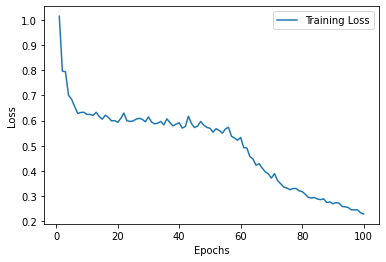

In [31]:
loss_values = lstmhistory.history['loss']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

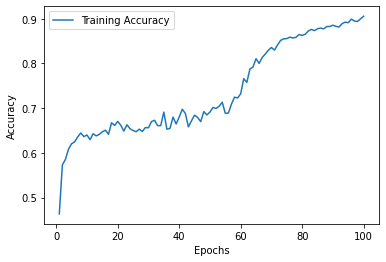

In [32]:
acc_values = lstmhistory.history['accuracy']
epochs = range(1, len(loss_values)+1)

plt.plot(epochs, acc_values, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [33]:
end = time.perf_counter()
print(f"notebook took {end - start:0.4f} seconds to finish")

notebook took 1050.4225 seconds to finish
